In [11]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import issparse, coo_matrix, csr_matrix, csc_matrix
from scipy.sparse.linalg import eigsh
from openfermionpyscf import run_pyscf
from openfermion import MolecularData, get_fermion_operator
from openfermion.linalg import get_sparse_operator,  get_number_preserving_sparse_operator


In [ ]:
def sparse_to_graph(A, *,
                    directed=False,
                    weight="value",   # "value" | "abs" | "binary"
                    symmetrize=True,  # 무향 그래프용: 패턴을 A + A.T로 합칠지
                    tol=0.0,          # |a_ij|<=tol 은 0 취급
                    keep_diagonal=False):
    """
    희소행렬 A -> NetworkX Graph/DiGraph 변환

    Parameters
    ----------
    A : scipy.sparse matrix (정방 추천)
    directed : bool
        True면 DiGraph, False면 Graph
    weight : {"value","abs","binary"}
        엣지 weight 설정 방법
        - "value": a_ij (실수/복소 가능; 복소는 실수부 사용 권장)
        - "abs"  : |a_ij|
        - "binary": 1 (연결만 표현)
    symmetrize : bool
        무향 그래프에서 A의 패턴을 A + A^T로 결합 (권장)
        directed=True 인 경우엔 무시됨
    tol : float
        임계값 이하 절댓값은 0으로 무시
    keep_diagonal : bool
        True면 i==j 항도 self-loop로 추가

    Returns
    -------
    G : nx.Graph or nx.DiGraph
    """
    if not issparse(A):
        raise ValueError("A must be a scipy.sparse matrix")
    # COO로 변환
    A = A.tocoo(copy=True)

    # tol 필터링
    if tol > 0:
        mask = np.abs(A.data) > tol
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 대각 요소 처리
    if not keep_diagonal:
        mask = A.row != A.col
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 무향이면 패턴 대칭화(권장): A <- A + A.T (중복은 합쳐짐)
    if not directed and symmetrize:
        AT = coo_matrix((A.data, (A.col, A.row)), shape=A.shape)
        A = (A + AT).tocoo()

    # 그래프 타입 선택
    G = nx.DiGraph() if directed else nx.Graph()
    G.add_nodes_from(range(A.shape[0]))  # 노드: 0..n-1

    # weight 설정
    if weight == "binary":
        # 동일 (i,j) 중복 합치기 위해 집계
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, A.data):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] = 1.0  # 존재만 표시
        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    else:
        # "value" 또는 "abs"
        if weight == "abs":
            vals = np.abs(A.data)
        elif weight == "value":
            # 복소인 경우 실수부만 쓰고 싶다면 .real 사용
            # 필요에 따라 변경 가능: vals = np.real(A.data)
            vals = A.data
        else:
            raise ValueError("weight must be 'value', 'abs', or 'binary'")

        # 동일 엣지 중복 합치기(무향일 때 i<j 묶기)
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, vals):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] += float(v)  # 누적(합). 필요시 max/mean 등으로 변경 가능.

        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    return G

In [13]:
def sparse_to_graph(A, *,
                    directed=False,
                    weight="value",   # "value" | "abs" | "binary"
                    symmetrize=True,  # 무향 그래프용: 패턴을 A + A.T로 합칠지
                    tol=0.0,          # |a_ij|<=tol 은 0 취급
                    keep_diagonal=False):
    """
    희소행렬 A -> NetworkX Graph/DiGraph 변환

    Parameters
    ----------
    A : scipy.sparse matrix (정방 추천)
    directed : bool
        True면 DiGraph, False면 Graph
    weight : {"value","abs","binary"}
        엣지 weight 설정 방법
        - "value": a_ij (실수/복소 가능; 복소는 실수부 사용 권장)
        - "abs"  : |a_ij|
        - "binary": 1 (연결만 표현)
    symmetrize : bool
        무향 그래프에서 A의 패턴을 A + A^T로 결합 (권장)
        directed=True 인 경우엔 무시됨
    tol : float
        임계값 이하 절댓값은 0으로 무시
    keep_diagonal : bool
        True면 i==j 항도 self-loop로 추가

    Returns
    -------
    G : nx.Graph or nx.DiGraph
    """
    if not issparse(A):
        raise ValueError("A must be a scipy.sparse matrix")
    # COO로 변환
    A = A.tocoo(copy=True)

    # tol 필터링
    if tol > 0:
        mask = np.abs(A.data) > tol
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 대각 요소 처리
    if not keep_diagonal:
        mask = A.row != A.col
        A = coo_matrix((A.data[mask], (A.row[mask], A.col[mask])), shape=A.shape)

    # 무향이면 패턴 대칭화(권장): A <- A + A.T (중복은 합쳐짐)
    if not directed and symmetrize:
        AT = coo_matrix((A.data, (A.col, A.row)), shape=A.shape)
        A = (A + AT).tocoo()

    # 그래프 타입 선택
    G = nx.DiGraph() if directed else nx.Graph()
    G.add_nodes_from(range(A.shape[0]))  # 노드: 0..n-1

    # weight 설정
    if weight == "binary":
        # 동일 (i,j) 중복 합치기 위해 집계
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, A.data):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] = 1.0  # 존재만 표시
        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    else:
        # "value" 또는 "abs"
        if weight == "abs":
            vals = np.abs(A.data)
        elif weight == "value":
            # 복소인 경우 실수부만 쓰고 싶다면 .real 사용
            # 필요에 따라 변경 가능: vals = np.real(A.data)
            vals = A.data
        else:
            raise ValueError("weight must be 'value', 'abs', or 'binary'")

        # 동일 엣지 중복 합치기(무향일 때 i<j 묶기)
        from collections import defaultdict
        edges = defaultdict(float)
        for i, j, v in zip(A.row, A.col, vals):
            if not directed and i == j and not keep_diagonal:
                continue
            key = (i, j) if directed else (min(i, j), max(i, j))
            edges[key] += float(v)  # 누적(합). 필요시 max/mean 등으로 변경 가능.

        for (i, j), w in edges.items():
            G.add_edge(i, j, weight=w)

    return G

In [14]:
def GBBD(mol):
    mol = run_pyscf(mol, run_scf=1, run_fci=0)
    # 3. 2차 정량화 Hamiltonian 얻기
    ham_int = mol.get_molecular_hamiltonian()
    ham_fci = get_fermion_operator(ham_int)     
    #H = get_sparse_operator(ham_fci, n_qubits=mol.n_qubits)
    H = get_number_preserving_sparse_operator(
    fermion_op=ham_fci,
    num_qubits=mol.n_qubits,
    num_electrons=mol.n_electrons,       # 필수
    spin_preserving=True ,        # S_z 고정 (필요 없으면 None)
    reference_determinant=None,
    excitation_level=None)
    print(H)
    H_real = H.real
    G = sparse_to_graph(H_real, directed=False, weight="abs", symmetrize=True, tol=0.0)
    ccs = list(nx.connected_components(G))
    
    sub_mat_idx_g = list(ccs[0])
    H_sub_g = H[sub_mat_idx_g, :][:, sub_mat_idx_g]
    print(H_sub_g)
    eigval_g, eigvec = eigsh(H_sub_g, k=1, which='SA')
    E_g = eigval_g[0]
    
    sub_mat_idx_e = list(ccs[1])
    H_sub_e = H[sub_mat_idx_e, :][:, sub_mat_idx_e]
    print(H_sub_e)
    eigval_e, eigvec = eigsh(H_sub_e, k=1, which='SA')
    E_e = eigval_e[0]
    
    return E_g, E_e



### 행렬만들기

In [15]:
dist = 0.7
#H2
H2_energy_arr_g = []
H2_energy_arr_e1 = []
for dist in np.arange(0.4,2.5, 0.1):
    geometry = [('H', (0., 0., 0.)),
                ('H', (dist, 0., 0.))]
    basis = 'sto-3g'
    mol = MolecularData(geometry, basis, multiplicity=1, charge=0)
    energy_g, energy_e1 = GBBD(mol)
    H2_energy_arr_g.append(energy_g)
    H2_energy_arr_e1.append(energy_e1)

#H4
H4_energy_arr_g = []
H4_energy_arr_e1 = []
for dist in np.arange(0.4,2.5, 0.1):
    geometry = [('H', (0., 0., 0.)),
                ('H', (dist, 0., 0. )),
                ('H', (2*dist, 0., 0. )),
                ('H', (3*dist, 0., 0.))]  # Angstrom
    basis = 'sto-3g'
    mol = MolecularData(geometry, basis, multiplicity=1, charge=0)
    energy_g, energy_e1 = GBBD(mol)
    H4_energy_arr_g.append((0.5)*energy_g)
    H4_energy_arr_e1.append((0.5)*energy_e1)

#H8
H8_energy_arr_g = []
H8_energy_arr_e1 = []
for dist in np.arange(0.4,2.5, 0.1):
    geometry = [('H', (0., 0., 0.)),
                ('H', (dist, 0., 0. )),
                ('H', (2*dist, 0., 0. )),
                ('H', (3*dist, 0., 0.)),
                ('H', (4*dist, 0., 0.)),
                ('H', (5*dist, 0., 0. )),
                ('H', (6*dist, 0., 0. )),
                ('H', (7*dist, 0., 0.))]

    basis = 'sto-3g'
    mol = MolecularData(geometry, basis, multiplicity=1, charge=0)
    energy_g, energy_e1 = GBBD(mol)
    H8_energy_arr_g.append((1/4)*energy_g)
    H8_energy_arr_e1.append((1/4)*energy_e1)
    
#H12
# H12_energy_arr = []
# for dist_bond in np.arange(0.4,2.5, 0.1):
#     geometry = [('H', (0., 0., 0.)),
#                 ('H', (dist, 0., 0. )),
#                 ('H', (2*dist, 0., 0. )),
#                 ('H', (3*dist, 0., 0.)),
#                 ('H', (4*dist, 0., 0.)),
#                 ('H', (5*dist, 0., 0. )),
#                 ('H', (6*dist, 0., 0. )),
#                 ('H', (7*dist, 0., 0.)),
#                 ('H', (8*dist, 0., 0.)),
#                 ('H', (9*dist, 0., 0. )),
#                 ('H', (10*dist, 0., 0. )),
#                 ('H', (11*dist, 0., 0.))]
#     basis = 'sto-3g'
#     mol = MolecularData(geometry, basis, multiplicity=1, charge=0)
#     energy_g, energy_e1 = (1/6)*GBBD(mol)
#     H8_energy_arr_g.append(energy_g)
#     H8_energy_arr_e1.append(energy_e1)


<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 8 stored elements and shape (4, 4)>
  Coords	Values
  (0, 0)	-0.9043613941635393
  (3, 0)	0.1645154240225661
  (1, 1)	0.4474495262936523
  (2, 1)	-0.1645154240225661
  (1, 2)	-0.1645154240225661
  (2, 2)	0.4474495262936523
  (0, 3)	0.1645154240225661
  (3, 3)	1.8509163240944293
<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 4 stored elements and shape (2, 2)>
  Coords	Values
  (0, 0)	-0.9043613941635393
  (1, 0)	0.1645154240225661
  (0, 1)	0.1645154240225661
  (1, 1)	1.8509163240944293
<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 4 stored elements and shape (2, 2)>
  Coords	Values
  (0, 0)	0.4474495262936523
  (1, 0)	-0.1645154240225661
  (0, 1)	-0.1645154240225661
  (1, 1)	0.4474495262936523
<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 8 stored elements and shape (4, 4)>
  Coords	Values
  (0, 0)	-1.0429962745400951
  (3, 0)	0.16887022768973542
  (1, 1)	0.098130113

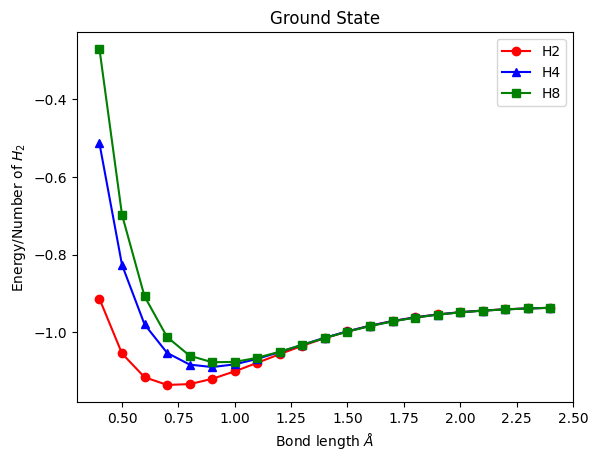

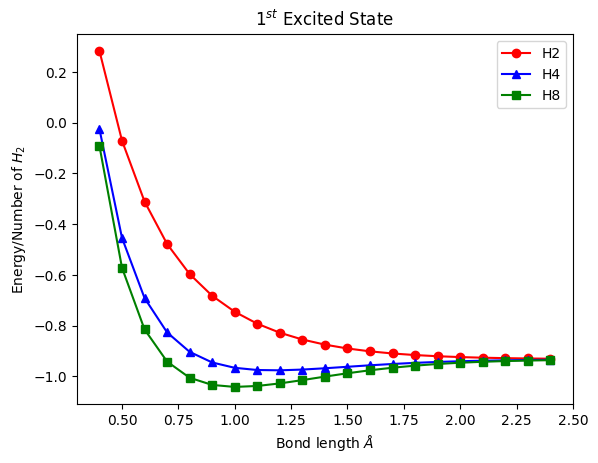

In [16]:
x = np.arange(0.4,2.5, 0.1)
plt.plot(x,H2_energy_arr_g,'-o', color='red',label='H2')
plt.plot(x,H4_energy_arr_g, '-^',color='blue',label='H4')
plt.plot(x,H8_energy_arr_g,'-s', color='green',label='H8')
#plt.plot(x,H12_energy_arr, color='purple',label='H12')
plt.title('Ground State')
plt.xlabel('Bond length $\\AA$')
plt.ylabel('Energy/Number of $H_2$')
plt.legend()
plt.show()


x = np.arange(0.4,2.5, 0.1)
plt.plot(x,H2_energy_arr_e1,'-o', color='red',label='H2')
plt.plot(x,H4_energy_arr_e1, '-^',color='blue',label='H4')
plt.plot(x,H8_energy_arr_e1,'-s', color='green',label='H8')
#plt.plot(x,H12_energy_arr, color='purple',label='H12')
plt.title('$1^{st}$ Excited State')
plt.xlabel('Bond length $\\AA$')
plt.ylabel('Energy/Number of $H_2$')
plt.legend()
plt.show()